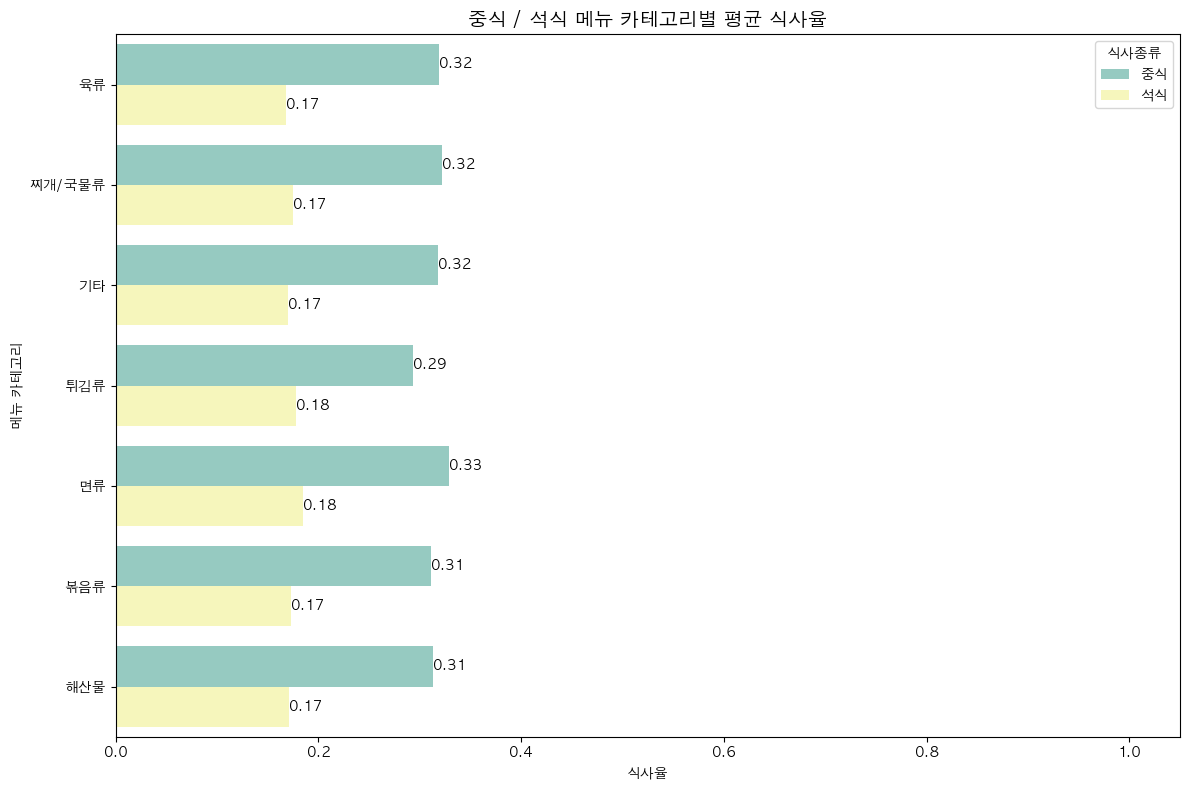

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict

# ✅ Mac 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 불러오기
df = pd.read_csv("../data/train.csv")
df["중식_식사율"] = df["중식계"] / df["본사정원수"]
df["석식_식사율"] = df["석식계"] / df["본사정원수"]

# 2. 메뉴 분리 함수
def split_menus(menu_string):
    if pd.isna(menu_string):
        return []
    menu_string = re.sub(r"[^\uAC00-\uD7A3a-zA-Z0-9\s]", "", menu_string)
    return list(set(menu_string.strip().split()))

df["중식_메뉴리스트"] = df["중식메뉴"].apply(split_menus)
df["석식_메뉴리스트"] = df["석식메뉴"].apply(split_menus)

# 3. 카테고리 키워드 정의
category_keywords = {
    "육류": ["제육", "불고기", "닭갈비", "소불고기", "갈비", "치킨", "닭", "찜닭", "삼겹살", "돈까스", "육"],
    "튀김류": ["돈까스", "튀김", "탕수육", "깐풍기", "후라이드", "까스", "치킨", "오징어튀김"],
    "찌개/국물류": ["찌개", "탕", "국", "짬뽕", "라면", "우동"],
    "볶음류": ["볶음", "덮밥", "비빔밥", "카레", "오므라이스", "볶음밥"],
    "면류": ["면", "우동", "스파게티", "짜장면", "쫄면", "국수", "라면", "파스타"],
    "해산물": ["오징어", "생선", "굴", "해물", "조개", "문어", "낙지"],
    #"채소류": ["아욱", "단무지", "연근", "열무", "곤드레", "양상추", "부추", "콩나물", "깻잎", "마늘", "치커리", "브로컬리", "오이", "호박", "김치"],
    "기타": []
}

# 4. 카테고리별 식사율 수집
cat_lunch = defaultdict(list)
cat_dinner = defaultdict(list)

for _, row in df.iterrows():
    for menu in row["중식_메뉴리스트"]:
        matched = False
        for cat, keywords in category_keywords.items():
            if any(kw in menu for kw in keywords):
                cat_lunch[cat].append(row["중식_식사율"])
                matched = True
                break
        if not matched:
            cat_lunch["기타"].append(row["중식_식사율"])

    for menu in row["석식_메뉴리스트"]:
        matched = False
        for cat, keywords in category_keywords.items():
            if any(kw in menu for kw in keywords):
                cat_dinner[cat].append(row["석식_식사율"])
                matched = True
                break
        if not matched:
            cat_dinner["기타"].append(row["석식_식사율"])

# 5. 평균 식사율 계산
cat_avg_lunch = {k: sum(v)/len(v) for k, v in cat_lunch.items() if len(v) >= 5}
cat_avg_dinner = {k: sum(v)/len(v) for k, v in cat_dinner.items() if len(v) >= 5}

# 6. 시각화용 데이터 구성
plot_df = pd.DataFrame({
    "카테고리": list(cat_avg_lunch.keys()),
    "중식": [cat_avg_lunch[k] for k in cat_avg_lunch],
    "석식": [cat_avg_dinner.get(k, 0) for k in cat_avg_lunch]
}).melt(id_vars="카테고리", var_name="식사종류", value_name="식사율")

# 7. 시각화
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=plot_df, x="식사율", y="카테고리", hue="식사종류", palette="Set3")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

plt.title("중식 / 석식 메뉴 카테고리별 평균 식사율", fontsize=14)
plt.xlabel("식사율")
plt.ylabel("메뉴 카테고리")
plt.xlim(0, 1.05)
plt.legend(title="식사종류")
plt.tight_layout()
plt.show()